## 라이브러리

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

plt.rc("font", family = 'Malgun Gothic')
plt.rc("axes", unicode_minus=False)
plt.style.use("ggplot")

## 데이터 보기

In [3]:
df = pd.read_table('./price_column_added.txt',sep=',') ## 경로는 각자 상황에 맞게 넣어주세요

In [4]:
df.head()

,Unnamed: 0,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,PRICE
0,0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,9018.160
1,1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,9018.160
2,2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,9018.160
3,3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,7376.125
4,4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,7376.125


In [5]:
## 칼럼보기

for col in df.columns:
    print(col)

Unnamed: 0
USER_ID
JOIN_DATE
D_TYPE
STORE_ID
GOODS_TYPE
DATE
COUNT
AD1
PRICE


## 데이터 전처리

In [6]:
## 문자열로된 날짜를 Timestamp형식으로 변환
df['JOIN_DATE'] = pd.to_datetime(df['JOIN_DATE'])
df['DATE'] = pd.to_datetime(df['DATE'])

In [7]:
## Unnamed: 0 컬럼 drop

df = df.drop("Unnamed: 0", axis=1)

In [8]:
## 데이터 크기와 결측치 확인

print('행 개수 : ',len(df)) ## 데이터 개수
df.isnull().sum() ## 결측치 확인

행 개수 :  879271


USER_ID       0
JOIN_DATE     0
D_TYPE        0
STORE_ID      0
GOODS_TYPE    0
DATE          0
COUNT         0
AD1           0
PRICE         0
dtype: int64

## 데이터 분석

In [9]:
from tqdm import tqdm
 
customer_id = list(df['USER_ID'].unique()) ## 유저아이디
 
## 먼저 각 유저아이디별로 구매금액이 얼마인지 알아보자.
monetary_df = pd.DataFrame()          ## 구매금액 데이터 초기화
monetary_df['USER_ID'] = customer_id  ## 유저아이디 삽입
 
monetary_data = []  ## 구매금액을 담을 리스트
for ci in tqdm(customer_id,position=0,desc='Calculating amount of individual customer'):
    temp = df.query('USER_ID==@ci')             ## 해당 아이디의 유저데이터 추출
    amount = sum(temp['COUNT'] * temp['PRICE']) ## 해당 유저 구매금액
    monetary_data.append(amount)
    
monetary_df['Monetary'] = monetary_data  ## 구매금액 데이터 삽입
 
## 각 유저별 최근방문일을 알아보자.
temp_recency_df = df[['USER_ID','DATE']].drop_duplicates()      ## 유저 아이디와 결제날짜만 추출한뒤 중복 제거
recency_df = temp_recency_df.groupby('USER_ID')['DATE'].max().reset_index() ## 아이디로 그룹화 한다음 최근방문일을 구해야 하므로 결제날짜에 max를 적용한다.
recency_df = recency_df.rename(columns={'DATE':'Recency'})
 
## 각 유저별 방문횟수를 알아보자.
frequency_df = df.groupby('USER_ID')['DATE'].count().reset_index() ## 아이디로 그룹화 한다음 방문횟수를 구해야 한다. 여기서는 방문횟수를 결제날짜 개수로 생각했으므로 결제날짜에 count를 적용한다.
frequency_df = frequency_df.rename(columns={'DATE':'Frequency'})
 
## 데이터를 유저아이디를 기준으로 합쳐야한다.
rfm_df = pd.merge(recency_df,frequency_df,how='left',on='USER_ID')
rfm_df = pd.merge(rfm_df,monetary_df,how='left',on='USER_ID')

Calculating amount of individual customer: 100%|█| 165425/165425 [30:45<00:00, 89.62it/s] 


In [11]:
## RFM 데이터프레임 확인

rfm_df

,USER_ID,Recency,Frequency,Monetary
0,224,2020-12-09,2,16394.285
1,232,2020-11-18,23,190537.495
2,342,2020-10-31,1,9018.160
3,565,2020-11-12,2,8558.325
4,729,2020-09-05,1,9018.160
...,...,...,...,...
165420,1830551,2020-12-31,1,1182.200
165421,1830570,2020-12-31,1,1182.200
165422,1830580,2020-12-31,1,1182.200
165423,1830589,2020-12-31,1,1182.200


In [12]:
## 데이터 변환(날짜를 수치로 표현하기 위한)

current_day = pd.to_datetime('20200101')## 기준 날짜는 2020년 1월 1일
time_diff = rfm_df['Recency']-current_day ## 최근방문일과 기준 날짜의 시간 차이

In [ ]:
time_diff

In [13]:
time_in_seconds = [x.total_seconds() for x in time_diff]  ## 시간 차이를 초단위로 계산
rfm_df['Recency'] = time_in_seconds   ## 변환된 데이터를 다시 삽입

### 최종 RFM 데이터프레임

In [14]:
rfm_df

,USER_ID,Recency,Frequency,Monetary
0,224,29635200.0,2,16394.285
1,232,27820800.0,23,190537.495
2,342,26265600.0,1,9018.160
3,565,27302400.0,2,8558.325
4,729,21427200.0,1,9018.160
...,...,...,...,...
165420,1830551,31536000.0,1,1182.200
165421,1830570,31536000.0,1,1182.200
165422,1830580,31536000.0,1,1182.200
165423,1830589,31536000.0,1,1182.200


### 점수 매기기 위한 구간 설정

In [15]:
## Recency 구분값(5구간) - (최소,최대값 기준)

Recency_list = []
for x in np.linspace(np.min(rfm_df['Recency']),np.max(rfm_df['Recency']),6)[1:-1]:
    Recency_list.append(x)
    print(f'구분값 : {x}')

구분값 : 6307200.0
구분값 : 12614400.0
구분값 : 18921600.0
구분값 : 25228800.0


In [16]:
## Recency 구분값(5구간) - (분위수 기준)
 
Recency_list2 = [] ## 분위수를 담을 리스트
for ql in np.linspace(0,1,6)[1:-1]:
    Recency_list2.append(np.quantile(rfm_df['Recency'],ql))
Recency_list2

[11145600.0, 18748800.0, 25056000.0, 28512000.0]

In [17]:
## Frequency 구분값(5구간) - (최소,최대값 기준)

Frequency_list = []
for x in np.linspace(np.min(rfm_df['Frequency']),np.max(rfm_df['Frequency']),6)[1:-1]:
    Frequency_list.append(x)
    print(f'구분값 : {x}')

구분값 : 74.0
구분값 : 147.0
구분값 : 220.0
구분값 : 293.0


In [18]:
## Frequency 구분값(5구간) - (분위수 기준)
 
Frequency_list2 = [] ## 분위수를 담을 리스트
for ql in np.linspace(0,1,6)[1:-1]:
    Frequency_list2.append(np.quantile(rfm_df['Frequency'],ql))
Frequency_list2

[1.0, 1.0, 2.0, 6.0]

In [19]:
## Monetary 구분값(5구간) - (최소,최대값 기준)

Monetary_list = []
for x in np.linspace(np.min(rfm_df['Monetary']),np.max(rfm_df['Monetary']),6)[1:-1]:
    Monetary_list.append(x)
    print(f'구분값 : {x}')

구분값 : 21923954.536
구분값 : 43846726.872
구분값 : 65769499.208000004
구분값 : 87692271.544


In [20]:
## Monetary 구분값(5구간) - (분위수 기준)
 
Monetary_list2 = [] ## 분위수를 담을 리스트
for ql in np.linspace(0,1,6)[1:-1]:
    Monetary_list2.append(np.quantile(rfm_df['Monetary'],ql))
Monetary_list2

[7376.125, 9018.16, 18036.32, 54108.96000000001]

## 데이터에 점수를 매겨주는 함수

In [21]:
def get_score(level, data):
    '''
    Description :
    level안에 있는 원소를 기준으로
    1 ~ len(level)+ 1 까지 점수를 부여하는 함수
    
    Parameters :
    level = 튜플 또는 리스트 타입의 숫자형 데이터이며 반드시 오름차순으로 정렬되어 있어야함.
    예 - [1,2,3,4,5] O, [5,4,3,2,1] X, [1,3,2,10,4] X 
    data = 점수를 부여할 데이터. 순회가능한(iterable) 데이터 형식
    return :
    점수를 담고 있는 리스트 반환
    '''
    score = [] 
    for j in range(len(data)): 
        for i in range(len(level)): 
            if data[j] <= level[i]: 
                score.append(i+1) 
                break 
            elif data[j] > max(level): 
                score.append(len(level)+1) 
                break 
            else: 
                continue 
    return score
    
def get_rfm_grade(df, num_class, rfm_tick_point, rfm_col_map, suffix=None):
    '''
    Description :
    개별 고객에 대한 최근방문일/방문횟수/구매금액 데이터가 주어졌을때
    최근방문일/방문횟수/구매금액 점수를 계산하여 주어진 데이터 오른쪽에 붙여줍니다.
    
    Parameters :
    df = pandas.DataFrame 데이터
    num_class = 등급(점수) 개수
    rfm_tick_point = 최근방문일/방문횟수/구매금액에 대해서 등급을 나눌 기준이 되는 값
                    'quantile', 'min_max' 또는 리스트를 통하여 직접 값을 정할 수 있음.
                    단, 리스트 사용시 원소의 개수는 반드시 num_class - 1 이어야함.
                    quatile = 데이터의 분위수를 기준으로 점수를 매김
                    min_max = 데이터의 최소값과 최대값을 동일 간격으로 나누어 점수를 매김
    rfm_col_map = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명
    예 - {'R':'Recency','F':'Frequency','M':'Monetary'}
    suffix = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명 뒤에 붙는 접미사
    Return : 
    pandas.DataFrame
    '''
    ##### 필요모듈 체크
    import pandas as pd
    import numpy as np
    from sklearn import preprocessing
    
    ##### 파라미터 체크
    if not isinstance(df, pd.DataFrame): ## 데이터는 pd.DataFrame이어야 함.
        print('데이터는 pandas.DataFrame 객체여야 합니다.')
        return
    
    if isinstance(rfm_tick_point, dict) == False or isinstance(rfm_col_map, dict) == False: ## rfm_tick_point와 rfm_col_map은 모두 딕셔너리
        print(f'rfm_tick_point와 rfm_col_map은 모두 딕셔너리여야합니다.')
        return
    
    if len(rfm_col_map) != 3: ## rfm_col_map에는 반드시 3개의 키를 가져아함.
        print(f'rfm_col_map인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if len(rfm_tick_point) != 3: ## rfm_tick_point에는 반드시 3개의 키를 가져아함.
        print(f'rfm_tick_point인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if set(rfm_tick_point.keys()) != set(rfm_col_map.keys()): ## rfm_tick_point와 rfm_col_map은 같은 키를 가져야함.
        print(f'rfm_tick_point와 rfm_col_map은 같은 키를 가져야 합니다.')
        return
    
    if not set(rfm_col_map.values()).issubset(set(df.columns)):
        not_in_df = set(rfm_col_map.values())-set(df.columns)
        print(f'{not_in_df}이 데이터 칼럼에 있어야 합니다.')
        return
    
    for k, v in rfm_tick_point.items():
        if isinstance(v, str):
            if not v in ['quantile','min_max']:
                print(f'{k}의 값은 "quantile" 또는 "min_max"중에 하나여야 합니다.')
                return
        elif isinstance(v,list) or isinstance(v,tuple):
            if len(v) != num_class-1:
                print(f'{k}에 대응하는 리스트(튜플)의 원소는 {num_class-1}개여야 합니다.')
                return
    
    if suffix:
        if not isinstance(suffix, str):
            print('suffix인자는 문자열이어야합니다.')
            return
        
    ##### 최근방문일/방문횟수/구매금액 점수 부여
    for k, v in rfm_tick_point.items():
        if isinstance(v,str):
            if v == 'quantile':
                ## 데이터 변환
                scale = preprocessing.StandardScaler() ## 데이터의 범위 조작하기 쉽게 해주는 클래스 
                temp_data = np.array(df[rfm_col_map[k]]) ## 데이터를 Numpy 배열로 변환
                temp_data = temp_data.reshape((-1,1)) ## scale을 적용하기위해 1차원 배열을 2차원으로 변환
                temp_data = scale.fit_transform(temp_data) ## 데이터를 평균은 0, 표준편차는 1을 갖도록 변환 
                temp_data = temp_data.squeeze() ## 데이터를 다시 1차원으로 변환
 
                ## 분위수 벡터
                quantiles_level = np.linspace(0,1,num_class+1)[1:-1] ## 분위수를 구할 기준값을 지정 0과 1은 제외
                quantiles = [] ## 분위수를 담을 리스트
                for ql in quantiles_level:
                    quantiles.append(np.quantile(temp_data,ql)) ## 분위수를 계산하고 리스트에 삽입
            else: ## min_max인 경우
                ## 데이터 변환
                temp_data = np.array(df[rfm_col_map[k]])
 
                ## 등분점 계산
                quantiles = np.linspace(np.min(temp_data),np.max(temp_data),num_class+1)[1:-1] ## 최소값과 최대값을 점수 개수만큼 등간격으로 분할하는 점
        else: ## 직접 구분값을 넣어주는 경우
            temp_data = np.array(df[rfm_col_map[k]])
            quantiles = v ## 직접 구분값을 넣어줌
        score = get_score(quantiles, temp_data) ## 구분값을 기준으로 점수를 부여하고 리스트로 저장한다.
        new_col_name = rfm_col_map[k]+'_'+k ## 점수값을 담는 변수의 이름
        if suffix:
            new_col_name = rfm_col_map[k]+'_'+suffix
        df[new_col_name] = score ## 기존데이터 옆에 점수 데이터를 추가한다.
    return df

In [22]:
rfm_tick_point={'R':'quantile','F':'quantile','M':'quantile'}
rfm_col_map={'R':'Recency','F':'Frequency','M':'Monetary'}
 
result = get_rfm_grade(df=rfm_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
# result.to_csv('주차장_RFM_result.csv',index=False)
result

,USER_ID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M
0,224,29635200.0,2,16394.285,5,3,3
1,232,27820800.0,23,190537.495,4,5,5
2,342,26265600.0,1,9018.160,4,1,2
3,565,27302400.0,2,8558.325,4,3,2
4,729,21427200.0,1,9018.160,3,1,2
...,...,...,...,...,...,...,...
165420,1830551,31536000.0,1,1182.200,5,1,1
165421,1830570,31536000.0,1,1182.200,5,1,1
165422,1830580,31536000.0,1,1182.200,5,1,1
165423,1830589,31536000.0,1,1182.200,5,1,1


사실 이상치를 제거하지 않고 점수를 매겼기 때문에,  
구분값이 적절한지에 대해서는 확인해 봐야할 것 같다  

In [23]:
result['total_score'] = result['Recency_R']+result['Frequency_F']+result['Monetary_M']
result

,USER_ID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M,total_score
0,224,29635200.0,2,16394.285,5,3,3,11
1,232,27820800.0,23,190537.495,4,5,5,14
2,342,26265600.0,1,9018.160,4,1,2,7
3,565,27302400.0,2,8558.325,4,3,2,9
4,729,21427200.0,1,9018.160,3,1,2,6
...,...,...,...,...,...,...,...,...
165420,1830551,31536000.0,1,1182.200,5,1,1,7
165421,1830570,31536000.0,1,1182.200,5,1,1,7
165422,1830580,31536000.0,1,1182.200,5,1,1,7
165423,1830589,31536000.0,1,1182.200,5,1,1,7


In [24]:
result.sort_values('total_score', ascending=False)

,USER_ID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M,total_score
26179,746189,29721600.0,64,577162.240,5,5,5,15
140051,1674603,30067200.0,7,176148.805,5,5,5,15
97652,1501933,31536000.0,77,708638.605,5,5,5,15
140103,1674844,31536000.0,12,108217.920,5,5,5,15
140102,1674840,31449600.0,7,63127.120,5,5,5,15
...,...,...,...,...,...,...,...,...
91118,1471840,1296000.0,1,1182.200,1,1,1,3
103747,1525699,6912000.0,1,1182.200,1,1,1,3
100670,1513772,5529600.0,1,1182.200,1,1,1,3
103749,1525713,6912000.0,1,1182.200,1,1,1,3


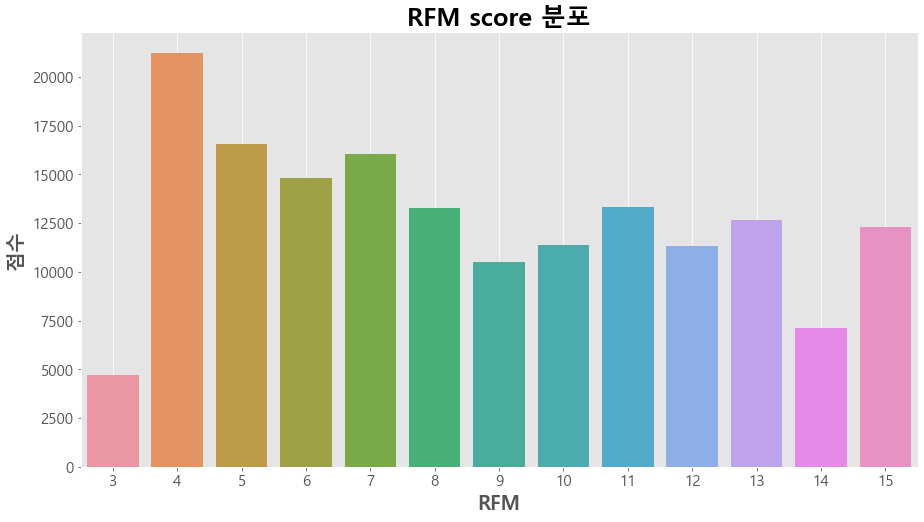

In [25]:
# RFM 전체 점수 barplotb

#plt.figure(figsize=(25,12))
fig, ax = plt.subplots(1,1, figsize = (15,8))
sns.set_palette("Paired", 9)
sns.countplot(x=result['total_score'], data=result,ax =ax)
plt.grid()
plt.title('RFM score 분포', fontsize=25, fontweight = 'bold')
plt.ylabel('점수', fontsize=20, fontweight = 'bold')
plt.xlabel('RFM', fontsize=20, fontweight = 'bold')
plt.tick_params(axis = "x", labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)

RFM 4점을 가진 유저가 제일 많음  
그 다음으로는 5,7,6,8점 순이다  
모두의 주차장 고객점수가 높지 않은편인것 같다  
이유를 찾아봐야 할듯  

In [27]:
# 4점 유저 경향

result_s4 = result.loc[(result['total_score']==4) & (result['Frequency_F'] != 1)]
result_s4

,USER_ID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M,total_score


4점 유저를 보니 최근성과 구매점수는 1~2점으로 분포되어 있지만,  
방문횟수는 1점밖에 없다.  
이것은 보통 앱 사용을 한번하고 다시 돌아오지 않는 유저들이 많다는 의미.  

In [28]:
# 5점 유저 경향

result_s5 = result.loc[(result['total_score']==5)]
result_s5

,USER_ID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M,total_score
10,2840,14256000.0,1,9018.160,2,1,2,5
16,3517,15638400.0,1,9018.160,2,1,2,5
45,10230,12614400.0,1,7376.125,2,1,2,5
48,10918,15552000.0,1,9018.160,2,1,2,5
49,10946,16243200.0,1,9018.160,2,1,2,5
...,...,...,...,...,...,...,...,...
150484,1733140,25056000.0,1,1182.200,3,1,1,5
150487,1733151,25056000.0,1,1182.200,3,1,1,5
150489,1733158,25056000.0,1,1182.200,3,1,1,5
150492,1733177,25056000.0,1,1182.200,3,1,1,5


In [29]:
result_s5.loc[(result['Frequency_F'] != 1)]

,USER_ID,Recency,Frequency,Monetary,Recency_R,Frequency_F,Monetary_M,total_score
406,33993,11059200.0,2,2364.4,1,3,1,5
660,50110,2592000.0,2,2364.4,1,3,1,5
671,51328,10886400.0,2,2364.4,1,3,1,5
1277,86826,2937600.0,2,2364.4,1,3,1,5
1350,90843,8640000.0,2,2364.4,1,3,1,5
...,...,...,...,...,...,...,...,...
109299,1547861,10540800.0,2,2364.4,1,3,1,5
109458,1548467,9849600.0,2,2364.4,1,3,1,5
109593,1549103,10972800.0,2,2364.4,1,3,1,5
110134,1551211,10540800.0,2,2364.4,1,3,1,5


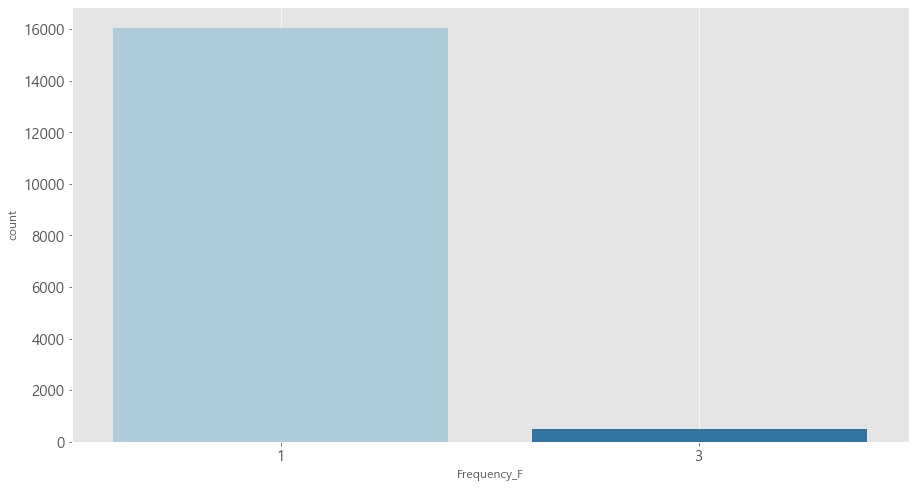

In [31]:
#plt.figure(figsize=(25,12))
fig, ax = plt.subplots(1,1, figsize = (15,8))
sns.set_palette("Paired", 9)
sns.countplot(x=result_s5['Frequency_F'], data=result_s5 ,ax =ax)
plt.grid()
# plt.title('RFM score 분포', fontsize=25, fontweight = 'bold')
# plt.ylabel('점수', fontsize=20, fontweight = 'bold')
# plt.xlabel('RFM', fontsize=20, fontweight = 'bold')
plt.tick_params(axis = "x", labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)

5점 유저도 방문횟수가 1점밖에 없을까? 싶었지만  
방문횟수 3점인 유저가 있었다. 이 의미는, 앱을 2번은 사용했다는 의미  
많은 유저들이 앱을 한번 사용 후, 돌아오지 않았지만, 그 다음 많은 유저들이 한번 더 방문했음  
다시 방문했을 이유를 알아보면 좋을 것 같음  

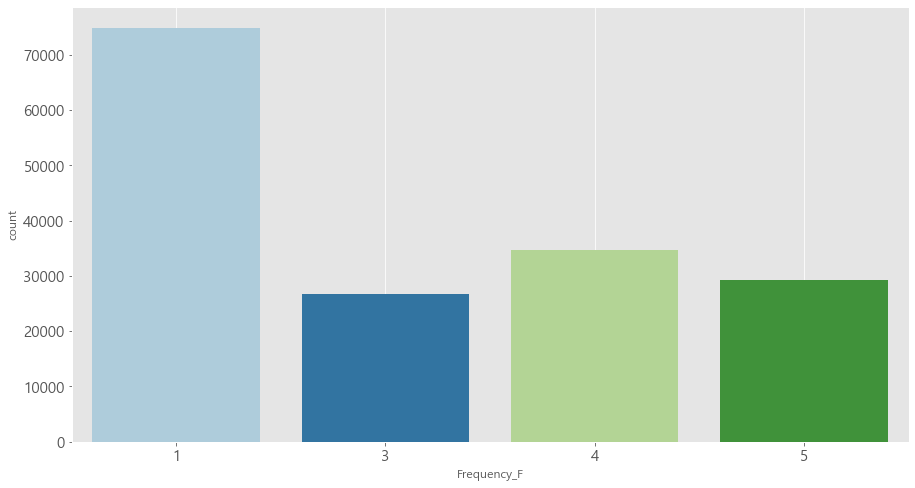

In [32]:
#plt.figure(figsize=(25,12))
fig, ax = plt.subplots(1,1, figsize = (15,8))
sns.set_palette("Paired", 9)
sns.countplot(x=result['Frequency_F'], data=result ,ax =ax)
plt.grid()
# plt.title('RFM score 분포', fontsize=25, fontweight = 'bold')
# plt.ylabel('점수', fontsize=20, fontweight = 'bold')
# plt.xlabel('RFM', fontsize=20, fontweight = 'bold')
plt.tick_params(axis = "x", labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)

```
> 확인하다보니, 방문횟수에서 2점을 주는 구분값도 1이고, 1점을 주는 구분값도 1이다.  
> 그래서 전체 데이터에서 방문횟수만 확인해보니 역시나 2점을 받은 유저는 없다ㅜㅜ
> 구분값을 다시 나눠야 하는걸까, 코드를 다시 살펴봐야할 것 같다  
```

In [ ]:
#plt.figure(figsize=(25,12))
fig, ax = plt.subplots(1,1, figsize = (15,8))
sns.set_palette("Paired", 9)
sns.barplot(x=result['total_score'], data=result,ax =ax)
plt.grid()
plt.title('RFM score 분포', fontsize=25, fontweight = 'bold')
plt.ylabel('점수', fontsize=20, fontweight = 'bold')
plt.xlabel('RFM', fontsize=20, fontweight = 'bold')
plt.tick_params(axis = "x", labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)

## 원본 데이터와 merge

In [34]:
df_new = pd.merge(result, df, how='inner', on='USER_ID')
df_new = df_new[['USER_ID','JOIN_DATE','D_TYPE','STORE_ID','GOODS_TYPE','DATE','COUNT','AD1','total_score']]
df_new

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,total_score
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,11
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,11
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,14
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,14
4,232,2013-12-17,BB,28018,C,2020-01-27,1,JRR,14
...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,7
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,7
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,7
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,7


In [35]:
df_new['DATE'] = pd.to_datetime(df_new['DATE'])
df_new['day'] = df_new['DATE'].dt.weekday
df_new

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,total_score,day
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,11,6
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,11,2
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,14,6
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,14,6
4,232,2013-12-17,BB,28018,C,2020-01-27,1,JRR,14,0
...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,7,3
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,7,3
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,7,3
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,7,3


In [37]:
# 3점 유저 패턴(제일 낮은 점수)

result_s3 = df_new.loc[(df_new['total_score']==3)]
result_s3

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,total_score,day
291,8299,2014-03-27,BB,1892,B,2020-02-14,1,GN,3,4
768,17101,2014-09-17,AA,109832,B,2020-01-30,1,GN,3,3
779,17801,2014-09-20,BB,106076,B,2020-02-26,1,J,3,2
1068,21370,2014-10-03,AA,182007,B,2020-01-22,1,J,3,2
1073,21678,2014-10-04,BB,220722,B,2020-01-10,1,BF,3,4
...,...,...,...,...,...,...,...,...,...,...
686335,1564461,2020-05-08,AA,91417,B,2020-05-08,2,SD,3,4
686363,1564534,2020-05-08,AA,219936,B,2020-05-08,1,YD,3,4
687075,1565058,2020-05-09,BB,220073,B,2020-05-09,1,J,3,5
687294,1565285,2020-05-09,AA,220073,B,2020-05-09,1,J,3,5


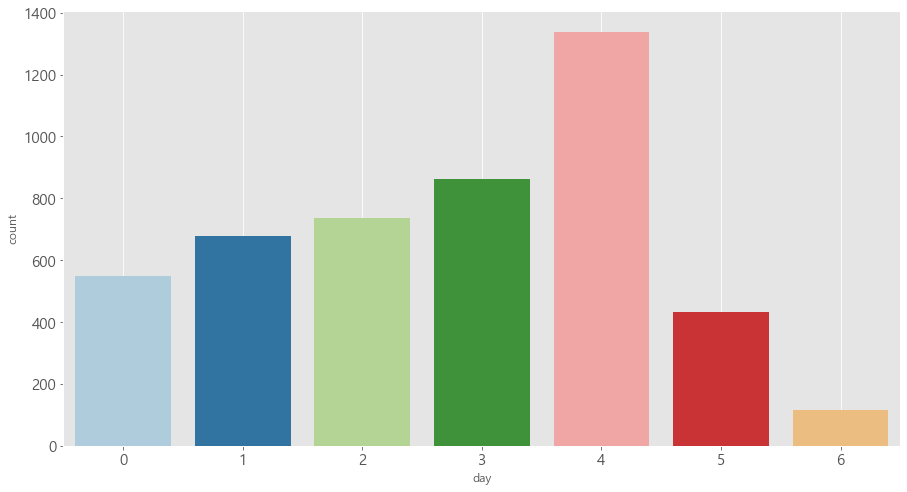

In [39]:
#plt.figure(figsize=(25,12))
fig, ax = plt.subplots(1,1, figsize = (15,8))
sns.set_palette("Paired", 9)
sns.countplot(x=result_s3['day'], data=result_s3,ax =ax)
plt.grid()
# plt.title('RFM score 분포', fontsize=25, fontweight = 'bold')
# plt.ylabel('점수', fontsize=20, fontweight = 'bold')
# plt.xlabel('RFM', fontsize=20, fontweight = 'bold')
plt.tick_params(axis = "x", labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)

0-6은 월-일 순.  
3점 유저는 월요일부터 금요일까지 사용량이 증가하다가 금요일에 최고점을 찍고,  
토요일, 일요일 주말은 평일에 비해 사용량이 극히 낮음  

금요일 퇴근 후, 차를 가지고 외식을 하거나, 친구를 만나거나 하는 용도로  
주차장앱을 사용하지 않았을까..(일회용)  
주말은 집에 차를 두고 외출을 하면 되서?  

#### 그렇다면, 15점 유저들의 사용 요일은 언제일까?

In [40]:
# 15점 유저 패턴(제일 높은 점수)

result_s15 = df_new.loc[(df_new['total_score']==15)]
result_s15

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1,total_score,day
154,5067,2014-02-04,BB,203763,C,2020-01-10,1,MP,15,4
155,5067,2014-02-04,BB,220611,A,2020-02-21,1,GSN,15,4
156,5067,2014-02-04,BB,182296,A,2020-05-15,1,SC,15,4
157,5067,2014-02-04,BB,182296,A,2020-05-19,1,SC,15,1
158,5067,2014-02-04,BB,182296,A,2020-05-20,1,SC,15,2
...,...,...,...,...,...,...,...,...,...,...
877791,1820289,2020-12-21,AA,219936,A,2020-12-27,1,YD,15,6
877792,1820289,2020-12-21,AA,219936,A,2020-12-28,1,YD,15,0
877793,1820289,2020-12-21,AA,219936,A,2020-12-29,1,YD,15,1
877794,1820289,2020-12-21,AA,219936,A,2020-12-30,1,YD,15,2


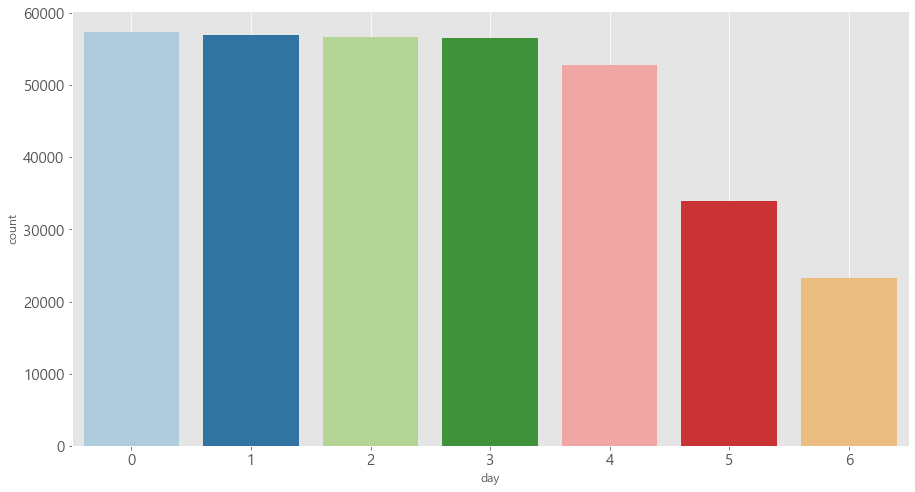

In [41]:
#plt.figure(figsize=(25,12))
fig, ax = plt.subplots(1,1, figsize = (15,8))
sns.set_palette("Paired", 9)
sns.countplot(x=result_s15['day'], data=result_s15, ax =ax)
plt.grid()
# plt.title('RFM score 분포', fontsize=25, fontweight = 'bold')
# plt.ylabel('점수', fontsize=20, fontweight = 'bold')
# plt.xlabel('RFM', fontsize=20, fontweight = 'bold')
plt.tick_params(axis = "x", labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)

15점 유저들도 주말에는 앱 사용량이 감소는 하나, 평일 내내 고르게 높은 사용치를 보여줌  
고점 유저들은 대부분 기업이지 않을까

### 시각화를 다양한 방면으로 해보고 싶지만, 점수 구분값이 못미더워서...
### 팀장님이 공유해주신 RFM점수 파일을 불러와서 EDA 해봐야할 것 같다